In [ ]:
%matplotlib inline

In [ ]:
%%notify -m "sleep for 5 secs"
import time
time.sleep(3)


# Orthogonal Matching Pursuit


Using orthogonal matching pursuit for recovering a sparse signal from a noisy
measurement encoded with a dictionary



In [ ]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import OrthogonalMatchingPursuitCV
from sklearn.datasets import make_sparse_coded_signal

n_components, n_features = 512, 100
n_nonzero_coefs = 17

# generate the data

# y = Xw
# |x|_0 = n_nonzero_coefs


y, X, w = make_sparse_coded_signal(n_samples=1,
                                   n_components=n_components,
                                   n_features=n_features,
                                   n_nonzero_coefs=n_nonzero_coefs,
                                   random_state=0)

In [ ]:
y.shape

In [ ]:
w

In [ ]:
X.shape

In [ ]:
idx, = w.nonzero()

# distort the clean signal
y_noisy = y + 0.05 * np.random.randn(len(y))

# plot the sparse signal
plt.figure(figsize=(7, 7))
plt.subplot(4, 1, 1)
plt.xlim(0, 512)
plt.title("Sparse signal")
plt.stem(idx, w[idx])

In [ ]:
y_noisy.shape

In [ ]:
# plot the noise-free reconstruction
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=n_nonzero_coefs)
omp.fit(X, y)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 2)
plt.xlim(0, 512)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r])

In [ ]:
# plot the noisy reconstruction
omp.fit(X, y_noisy)
coef = omp.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 3)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements")
plt.stem(idx_r, coef[idx_r])

In [ ]:
# plot the noisy reconstruction with number of non-zeros set by CV
omp_cv = OrthogonalMatchingPursuitCV(cv=5)
omp_cv.fit(X, y_noisy)
coef = omp_cv.coef_
idx_r, = coef.nonzero()
plt.subplot(4, 1, 4)
plt.xlim(0, 512)
plt.title("Recovered signal from noisy measurements with CV")
plt.stem(idx_r, coef[idx_r])

In [ ]:
plt.subplots_adjust(0.06, 0.04, 0.94, 0.90, 0.20, 0.38)
plt.suptitle('Sparse signal recovery with Orthogonal Matching Pursuit',
             fontsize=16)
plt.show()

In [48]:
import spectrogram
import os
import sys
import time
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import dict_learning

In [49]:
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [50]:
digfile_name = os.path.basename(os.path.normpath("GEN3CH_4_009.dig"))

In [51]:
sp = spectrogram.Spectrogram(digfile_name)
sp_bp = spectrogram.Spectrogram(digfile_name)

In [52]:
sgram = sp.spectrogram(0,50e-6)
sgram_bp = sp_bp.spectrogram(0,50e-6)

In [71]:
sbp1 = sgram['spectrogram']
sbp2 = sgram_bp['spectrogram']

In [79]:
sbp2 = sbp2.transpose()

In [67]:
# sbp1.shape

In [68]:
# omp = OrthogonalMatchingPursuit(n_nonzero_coefs=5)


In [80]:
for i, column in enumerate(sbp2):
    print(column.shape)
    code, dictionary, errors = dict_learning(column, n_components=5, alpha=.70, max_iter=20)
    sbp2[i] = np.dot(code, dictionary)
    
print(sbp2.shape)
print(sbp1.shape)


(4097,)


ValueError: expected matrix

In [ ]:
# %%notify -o

# code, dictionary, errors = dict_learning(sbp1, n_components=5, alpha=.70, max_iter=20)

# 'dictionary learning finished'

In [ ]:
# code.shape

In [ ]:
# dictionary.shape

In [ ]:
# sgram_bp_new = np.dot(code, dictionary)

In [ ]:
# difference = sgram_bp_new - sgram['spectrogram']
# # difference.shape

# product = sgram_bp_new * sgram['spectrogram']
# # product.shape

# quotient = sgram_bp_new / sgram['spectrogram']
# # quotient.shape

In [36]:
# sgram['spectrogram'].shape

(4097, 348)

In [ ]:
axes1 = plt.axes()
sgram_bp['spectrogram'] = sbp2
sp.plot(axes1, sgram_bp)

In [ ]:
axes2 = plt.axes()
sp.plot(axes2, sgram)

In [37]:
from __future__ import print_function
from builtins import input
from builtins import range

import numpy as np

from sporco.admm import bpdn
from sporco import util
from sporco import plot
plot.config_notebook_plotting()


In [38]:
N = 4097      # Signal size
M = 438   # Dictionary size
L = 10       # Number of non-zero coefficients in generator
sigma = 0.5  # Noise level


In [39]:
# Construct random dictionary and random sparse coefficients
np.random.seed(12345)
D = np.random.randn(N, M)
x0 = np.zeros((M, 1))
si = np.random.permutation(list(range(0, M-1)))
x0[si[0:L]] = np.random.randn(L, 1)

# Construct reference and noisy signal
s0 = D.dot(x0)
s = s0 + sigma*np.random.randn(N,1)

In [43]:
print(x0.shape)
print(s0.shape)
print(D.shape)

(438, 1)
(4097, 1)
(4097, 438)


In [44]:
opt = bpdn.BPDN.Options({'Verbose': False, 'MaxMainIter': 500,
                    'RelStopTol': 1e-3, 'AutoRho': {'RsdlTarget': 1.0}})


In [45]:
# Function computing reconstruction error at lmbda
def evalerr(prm):
    lmbda = prm[0]
    b = bpdn.BPDN(D, s, lmbda, opt)
    x = b.solve()
    return np.sum(np.abs(x-x0))


# Parallel evalution of error function on lmbda grid
lrng = np.logspace(1, 2, 20)
sprm, sfvl, fvmx, sidx = util.grid_search(evalerr, (lrng,))
lmbda = sprm[0]

print('Minimum ℓ1 error: %5.2f at 𝜆 = %.2e' % (sfvl, lmbda))


Minimum ℓ1 error:  0.22 at 𝜆 = 6.95e+01


In [46]:
# Initialise and run BPDN object for best lmbda
opt['Verbose'] = True
b = bpdn.BPDN(D, s, lmbda, opt)
x = b.solve()

print("BPDN solve time: %.2fs" % b.timer.elapsed('solve'))


Itn   Fnc       DFid      Regℓ1     r         s         ρ       
----------------------------------------------------------------
   0  1.13e+03  6.06e+02  7.57e+00  4.36e-01  8.21e+00  3.48e+03
   1  9.91e+02  5.14e+02  6.87e+00  5.52e-02  1.20e+00  3.48e+03
   2  9.91e+02  5.14e+02  6.86e+00  1.30e-02  8.09e-02  3.48e+03
   3  9.90e+02  5.15e+02  6.84e+00  3.23e-03  3.42e-02  3.48e+03
   4  9.90e+02  5.15e+02  6.84e+00  9.05e-04  7.87e-03  3.48e+03
   5  9.90e+02  5.15e+02  6.84e+00  2.89e-04  1.64e-03  3.48e+03
   6  9.90e+02  5.15e+02  6.84e+00  1.01e-04  3.65e-04  3.48e+03
----------------------------------------------------------------
BPDN solve time: 0.02s


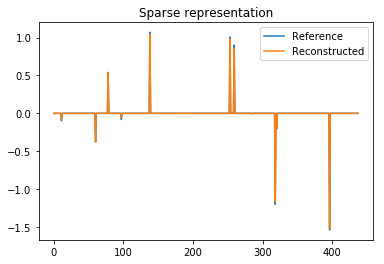

In [47]:
plot.plot(np.hstack((x0, x)), title='Sparse representation',
          lgnd=['Reference', 'Reconstructed'])


In [22]:
L = 2

In [23]:
N = 5

In [24]:
M = 4*N

In [25]:
D = np.random.randn(N, M)
D.shape

(5, 20)

In [26]:
D

array([[-1.61626009, -1.07983235,  0.66679199,  1.58362562, -1.09179905,
        -0.34561363,  0.80384697,  0.65372569, -1.28700934, -2.2131691 ,
        -0.60997058, -1.62813229,  1.58591316,  0.7495613 ,  0.42910988,
        -1.45566402,  1.23059461,  0.57307666,  0.68986824, -0.59012879],
       [-0.53093704, -1.57836045, -0.71006919,  0.96883648,  1.64428728,
         0.49937811,  0.88322784, -2.58115677, -0.87129026,  0.93404375,
         0.89278247,  0.59733721, -0.30695923, -0.06653112, -2.38502601,
        -0.72074212, -1.5920858 , -0.26831971, -2.44717994,  1.54080631],
       [-0.20672133, -1.35996078, -1.21111407,  0.95177442, -0.32097569,
        -0.41301312,  0.06953077, -1.19412647, -0.1183899 ,  0.40879213,
         0.69016425, -0.47302659, -0.97099078, -0.29682705, -0.51676163,
        -1.02987551,  1.87663064, -0.28805682,  0.59851011,  0.11268812],
       [-0.31222359, -1.74280736,  1.30055701, -0.86982835, -1.02472461,
         1.88510694, -0.33560057,  1.50040682,  

In [27]:
x0 = np.zeros((M, 1))
x0

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [28]:
si = np.random.permutation(list(range(0, M-1)))
si

array([ 7, 18, 13, 11,  6, 14,  2, 15,  0,  5, 10, 12, 16,  4,  3,  9, 17,
        8,  1])

In [29]:
x0[si[0:L]] = np.random.randn(L, 1)
x0

array([[ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.88445311],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [-0.42621548],
       [ 0.        ]])